# Import Libraries

In [24]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Input
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold, cross_validate
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report, f1_score

# Load Data

In [2]:
X_train, X_test, Y_train, Y_test = joblib.load("../data/processed/split_data.pkl")
X_train_scaled, X_test_scaled, _, _ = joblib.load("../data/processed/split_scaled_data.pkl")

# Evaluate Bagging and Ensemeble Models on Test Set Function

In [3]:
def evaluate_on_test(model, X_test, Y_test, name):
    """
    Evaluate model on test set and print results.
    """
    Y_pred = model.predict(X_test)
    Y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\nTest Set Results of {name}:")
    print(f"ROC AUC: {roc_auc_score(Y_test, Y_proba):.4f}")
    print(f"PR AUC: {average_precision_score(Y_test, Y_proba):.4f}")
    print(f"F1 Score: {f1_score(Y_test, Y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(Y_test, Y_pred))
    print("Classification Report:")
    print(classification_report(Y_test, Y_pred))

# Bagging Model (Random Forest)

In [4]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_scores = cross_validate(rf_model, X_train, Y_train, scoring=["roc_auc", "f1", "average_precision"], cv=cv, return_train_score=False)
print("Cross Validation Results of Random Forest:")
for metric, value in rf_scores.items():
    print(f"{metric}: {np.mean(value):.4f}")
    
rf_model.fit(X_train, Y_train)
evaluate_on_test(rf_model, X_test, Y_test, "Random Forest")

Cross Validation Results of Random Forest:
fit_time: 75.0025
score_time: 0.3198
test_roc_auc: 0.9452
test_f1: 0.8338
test_average_precision: 0.8347

Test Set Results of Random Forest:
ROC AUC: 0.9479
PR AUC: 0.8464
F1 Score: 0.8324
Confusion Matrix:
[[56861     3]
 [   26    72]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.73      0.83        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962



# Bagging Model (Random Forest with SMOTE)

In [5]:
rf_smote_pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42))])

rf_smote_scores = cross_validate(rf_smote_pipeline, X_train, Y_train, scoring=["roc_auc", "f1", "average_precision"], cv=cv, return_train_score=False)
print("Cross Validation Results of Random Forest with SMOTE:")
for metric, value in rf_smote_scores.items():
    print(f"{metric}: {np.mean(value):.4f}")
    
rf_smote_pipeline.fit(X_train, Y_train)
evaluate_on_test(rf_smote_pipeline, X_test, Y_test, "Random Forest with SMOTE")

Cross Validation Results of Random Forest with SMOTE:
fit_time: 226.4683
score_time: 0.5230
test_roc_auc: 0.9746
test_f1: 0.8319
test_average_precision: 0.8355

Test Set Results of Random Forest with SMOTE:
ROC AUC: 0.9735
PR AUC: 0.8702
F1 Score: 0.8482
Confusion Matrix:
[[56852    12]
 [   17    81]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



# Boosting Model (XGBoost)

In [6]:
scale_pos_weight = (Y_train == 0).sum() / (Y_train == 1).sum()
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric="logloss")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_scores = cross_validate(xgb_model, X_train, Y_train, scoring=["roc_auc", "f1", "average_precision"], cv=cv, return_train_score=False)
print("Cross Validation Results of XGBoost:")
for metric, value in xgb_scores.items():
    print(f"{metric}: {np.mean(value):.4f}")
    
xgb_model.fit(X_train, Y_train)
evaluate_on_test(xgb_model, X_test, Y_test, "XGBoost")

Cross Validation Results of XGBoost:
fit_time: 1.2153
score_time: 0.0580
test_roc_auc: 0.9818
test_f1: 0.8589
test_average_precision: 0.8411

Test Set Results of XGBoost:
ROC AUC: 0.9726
PR AUC: 0.8751
F1 Score: 0.8571
Confusion Matrix:
[[56854    10]
 [   17    81]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.83      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



# Boosting Model (XGBoost with SMOTE)

In [7]:
xgb_smote_pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("xgb", XGBClassifier(scale_pos_weight=1, random_state=42, eval_metric="logloss"))])

xgb_smote_scores = cross_validate(xgb_smote_pipeline, X_train, Y_train, scoring=["roc_auc", "f1", "average_precision"], cv=cv, return_train_score=False)
print("Cross Validation Results of XGBoost with SMOTE:")
for metric, value in xgb_smote_scores.items():
    print(f"{metric}: {np.mean(value):.4f}")
    
xgb_smote_pipeline.fit(X_train, Y_train)
evaluate_on_test(xgb_smote_pipeline, X_test, Y_test, "XGBoost with SMOTE")

Cross Validation Results of XGBoost with SMOTE:
fit_time: 2.5740
score_time: 0.0665
test_roc_auc: 0.9804
test_f1: 0.7873
test_average_precision: 0.8449

Test Set Results of XGBoost with SMOTE:
ROC AUC: 0.9814
PR AUC: 0.8645
F1 Score: 0.8077
Confusion Matrix:
[[56838    26]
 [   14    84]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.86      0.81        98

    accuracy                           1.00     56962
   macro avg       0.88      0.93      0.90     56962
weighted avg       1.00      1.00      1.00     56962



# Neural Network (MLP)

In [18]:
mlp_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

mlp_model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=["AUC", "Precision", "Recall"])
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_mlp = mlp_model.fit(X_train_scaled, Y_train, validation_split=0.2, epochs=50, batch_size=512, callbacks=[early_stopping], verbose=1)

Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8202 - Precision: 0.0064 - Recall: 0.7613 - loss: 0.5510 - val_AUC: 0.8791 - val_Precision: 0.8971 - val_Recall: 0.7349 - val_loss: 0.0409
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8116 - Precision: 0.3270 - Recall: 0.6172 - loss: 0.0455 - val_AUC: 0.9159 - val_Precision: 0.8784 - val_Recall: 0.7831 - val_loss: 0.0108
Epoch 3/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8702 - Precision: 0.6340 - Recall: 0.5816 - loss: 0.0152 - val_AUC: 0.9266 - val_Precision: 0.8919 - val_Recall: 0.7952 - val_loss: 0.0070
Epoch 4/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9131 - Precision: 0.7008 - Recall: 0.6639 - loss: 0.0098 - val_AUC: 0.9273 - val_Precision: 0.9118 - val_Recall: 0.7470 - val_loss: 0.0054
Epoch 5/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9012 - Precision: 0.8077 - Recall: 0.6490 - loss: 0.0066 - val_AUC: 0.9275 - val_Precision: 0.9000 - val_Recall: 0.6506 - val_loss: 0.0049


# Neural Network (MLP with SMOTE)

In [19]:
smote = SMOTE(random_state=42)
X_train_smote, Y_train_smote = smote.fit_resample(X_train_scaled, Y_train)

mlp_smote_model = Sequential([
    Input(shape=(X_train_smote.shape[1],)),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

mlp_smote_model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=["AUC", "Precision", "Recall"])
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_mlp_smote = mlp_smote_model.fit(X_train_smote, Y_train_smote, validation_split=0.2, epochs=50, batch_size=512, callbacks=[early_stopping], verbose=1)

Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9722 - Precision: 0.9247 - Recall: 0.8975 - loss: 0.1729 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 0.9826 - val_loss: 0.0451
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9988 - Precision: 0.9798 - Recall: 0.9792 - loss: 0.0416 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 0.9964 - val_loss: 0.0170
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9994 - Precision: 0.9873 - Recall: 0.9902 - loss: 0.0245 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 0.9992 - val_loss: 0.0067
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9995 - Precision: 0.9911 - Recall: 0.9946 - loss: 0.0177 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 0.9992 - val_loss: 0.0057
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9997 - Precision: 0.9929 - Recall: 0.9956 - loss: 0.0136 - val_AUC: 0.0000e+00 - val_Precision: 1.0000 - val_Recall: 0.9996

# Plot Training and Validation Curves

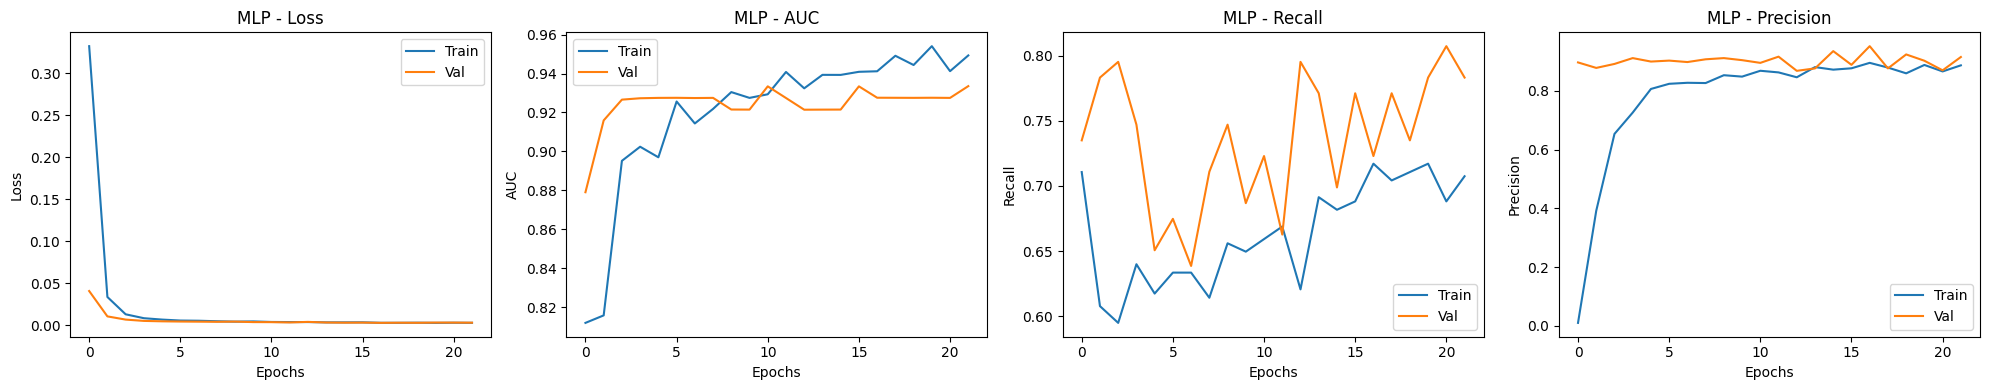

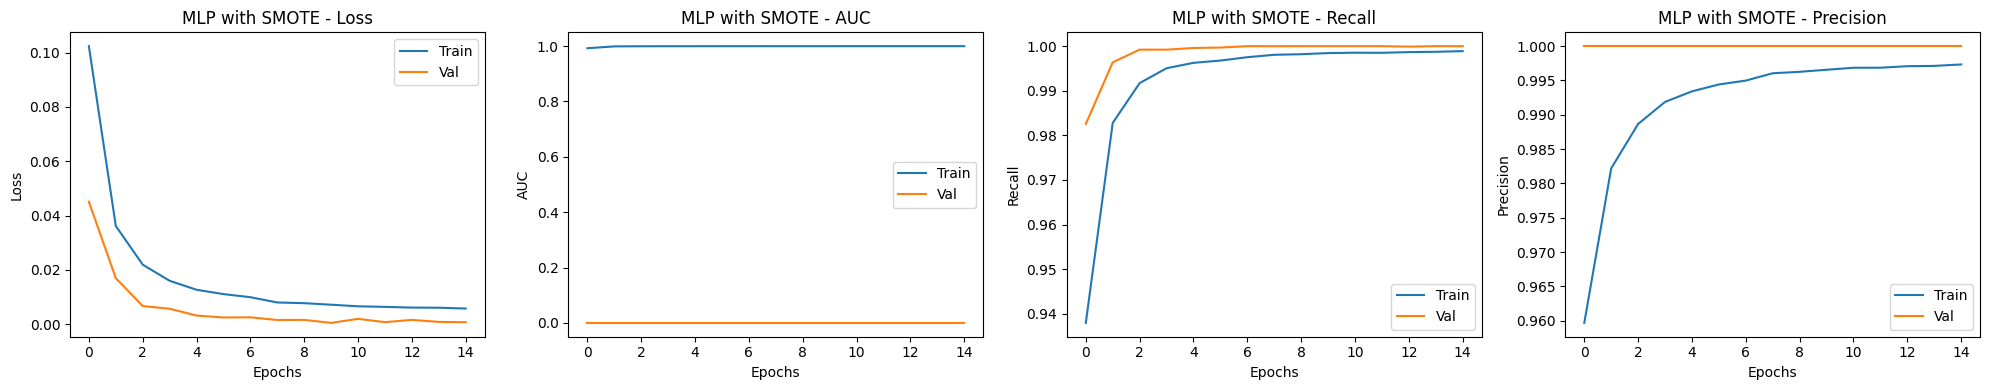

In [21]:
def plot_history(history, title):
    """
    Plot training history.
    """
    plt.figure(figsize=(20, 4))
    
    # Plot Loss
    plt.subplot(1, 4, 1)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot AUC
    plt.subplot(1, 4, 2)
    plt.plot(history.history["AUC"], label="Train")
    plt.plot(history.history["val_AUC"], label="Val")
    plt.title(f"{title} - AUC")
    plt.xlabel("Epochs")
    plt.ylabel("AUC")
    plt.legend()
    
    # Plot Recall
    plt.subplot(1, 4, 3)
    plt.plot(history.history["Recall"], label="Train")
    plt.plot(history.history["val_Recall"], label="Val")
    plt.title(f"{title} - Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()
    
    # Plot Precision
    plt.subplot(1, 4, 4)
    plt.plot(history.history["Precision"], label="Train")
    plt.plot(history.history["val_Precision"], label="Val")
    plt.title(f"{title} - Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
plot_history(history_mlp, "MLP")
plot_history(history_mlp_smote, "MLP with SMOTE")

# Evaluate MLP Models on Test Set

In [22]:
def evaluate_mlp(model, X_test, Y_test, name):
    """
    Evaluate MLP model on test set and print results.
    """
    Y_pred_proba = model.predict(X_test).flatten()
    Y_pred = (Y_pred_proba > 0.5).astype(int)
    

    print(f"\nTest Set Results of {name}:")
    print(f"ROC AUC: {roc_auc_score(Y_test, Y_pred_proba):.4f}")
    print(f"PR AUC: {average_precision_score(Y_test, Y_pred_proba):.4f}")
    print(f"F1 Score: {f1_score(Y_test, Y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(Y_test, Y_pred))
    print("Classification Report:")
    print(classification_report(Y_test, Y_pred))
    
evaluate_mlp(mlp_model, X_test_scaled, Y_test, "MLP")
evaluate_mlp(mlp_smote_model, X_test_scaled, Y_test, "MLP with SMOTE")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step

Test Set Results of MLP:
ROC AUC: 0.9751
PR AUC: 0.8460
F1 Score: 0.8023
Confusion Matrix:
[[56856     8]
 [   27    71]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.72      0.80        98

    accuracy                           1.00     56962
   macro avg       0.95      0.86      0.90     56962
weighted avg       1.00      1.00      1.00     56962

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step

Test Set Results of MLP with SMOTE:
ROC AUC: 0.9790
PR AUC: 0.8491
F1 Score: 0.7124
Confusion Matrix:
[[56812    52]
 [   15    83]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.61      0.85      0.71        98

    accuracy                           1.00     56962
   macro avg       0.81      0.92      0.86     56962
weighted

# Compare Models Based on Most Relevent Metrics

![alt text](metrics.png)


![alt text](model_leaderboard.png)

# Modeling Insights

- **SMOTE (Synthetic Minority Oversampling Technique)** had a varied impact:
    - On **XGBoost**, **SMOTE increased recall slightly** but **reduced precsion significantly**, leading to **more false positives** and a **lower F1 score**. This tradeoff is not favorable for businesses where excessive false alerts are costly.
    - On **Random Forest**, **SMOTE improved recall and PR AUC**, showing that decision tree models that lack built-in class imbalance support benfit from oversampling of the data itself.
    - On **MLP**, **SMOTE led to a high recall but a very low precision** indicating **potential overfitting to oversampled synthetic data**.
- **MLP without SMOTE** produced **strong precsion but lower recall**, making it a safer choice in situations where false positives are costly but is **less suitable for fraud detection**.
- **Random Forest without SMOTE** perfromed well but showed **weaker recall**.
- Models were evaluated using **stratified K-fold cross validation** and tested on a **held-out dataset** with **SMOTE applied only within the training folds** to avoid data leakage.
- The three main metrics used to select the best model was **PR AUC, Recall, and Precision**. **PR AUC** was prioritized over **ROC AUC** as the due to **severe class imbalance**, which makes PR AUC a better indicator of performance on rare fraud cases.
    - **High Recall reduces financial loss from undetected fraud.**
    - **High Precision avoids wasting time and money on false alarms.**
    - **High PR AUC indicates the model works well across many thresholds, crucial for threshold tuning in cost-senstive systems.**
- **XGBoost without SMOTE** emerged as the **best-performing model overall**, achieving the **highest PR-AUC and F1 score** while maintaing a **strong balance between recall and precsion**. It also **trained the fastest with low risk of overfitting** making it more **ideal for deployment and optimization**.